# Project (2) NASA Data Acquisation, Visualization, and Analysis 

 During the course we have to work with two data visualization and analysis projects. 
 This is the second project. In this project we will work on Pyhton notebook "5_nasa_data_collection_and_visualization.ipynb" and focuses on the acquisition and visualization of NASA data.and with its associated source folder (src) that consist of proejc source files.   

In [2]:
# The code makes sure that once there is change in the 'src/' folder, the 
# change will be automatically reloaded in the notebook.
%reload_ext autoreload
%autoreload 2
%aimport src

## NASA Data Acquisation

### Task 1: Understanding the NASA API and Data Collection

- The first taks is to register ourselves for a NASA API key and get knowing the different types of data that the API provides.
- Then we will run the Python script below to fetch data about **Near Earth Objects (NEOs)** from the NASA API for a years data.
- We will extract and analyze the distinct data elements provided for each NEO to gain a comprehensive understanding.

In [3]:
# We import all necersary liberaries at først: 
import requests
import time
from datetime import datetime, timedelta
from getpass import getpass
import json
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import plotly.express as px
import matplotlib.dates as mdates
import statistics

In [79]:
# This python script ask and register our given NASA Api-key:

# Set your NASA API KEY, this step asks you to enter your API KEY.
# (The input box may be float in the top on your editor.)
#api_key = getpass()

# The code is commented because we have loaded the data and for not being bothered

In [80]:
# This code block for fetching data from api, see use_data_from_local_file bool
"""
# Set the start and end dates for the data you want to fetch
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
end_date = start_date + timedelta(days=num_days)  # 1 year later
# change above to full year!
# Initialize a list to store the data
data = []

# Fetch data from the NASA API 7 days at a time
# The introduction of the API is on https://api.nasa.gov, under "Browse APIs" -> "Asteroids NeoWs"
# You can look into the example query in the link below to see what the data look like:
# https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY
current_date = start_date
while current_date < end_date and use_data_from_local_file == False:
    next_date = min(current_date + timedelta(days=7), end_date)
    # print("Current date: ", current_date)
    # print("Next date: ", next_date)
    response = requests.get(f'https://api.nasa.gov/neo/rest/v1/feed?start_date={current_date.strftime("%Y-%m-%d")}&end_date={next_date.strftime("%Y-%m-%d")}&api_key={api_key}')
    data.append(response.json())
    current_date = next_date
    time.sleep(1)  # To avoid hitting the rate limit
"""
# Now 'data' contains the NEO data for the 1-year period

'\n# Set the start and end dates for the data you want to fetch\nstart_date = datetime.strptime(\'2022-01-01\', \'%Y-%m-%d\')\nend_date = start_date + timedelta(days=num_days)  # 1 year later\n# change above to full year!\n# Initialize a list to store the data\ndata = []\n\n# Fetch data from the NASA API 7 days at a time\n# The introduction of the API is on https://api.nasa.gov, under "Browse APIs" -> "Asteroids NeoWs"\n# You can look into the example query in the link below to see what the data look like:\n# https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY\ncurrent_date = start_date\nwhile current_date < end_date and use_data_from_local_file == False:\n    next_date = min(current_date + timedelta(days=7), end_date)\n    # print("Current date: ", current_date)\n    # print("Next date: ", next_date)\n    response = requests.get(f\'https://api.nasa.gov/neo/rest/v1/feed?start_date={current_date.strftime("%Y-%m-%d")}&end_date={next_date.strft

In [4]:
# This code will utilize data from a local file as opposed to retrieving it from an external source.
use_data_from_local_file = True
num_days = 367

In [5]:
# This code block for fetching data from local file, see use_data_from_local_file bool
if use_data_from_local_file:
    file_path = 'src/a_years_nasa_data.json' 
    with open(file_path) as f:
        data = json.load(f)
    
# Check the date coverage of your data.
print("Number of days of data used: ", num_days)
print("Number of weeks of data used:", len(data))

Number of days of data used:  367
Number of weeks of data used: 53


In [6]:
# An empty list called neo_data is created to store the NEOs.

neo_data = []
for d in data:
   neo_data += list(d['near_earth_objects'].keys())

# Removing duplicates in loaded NEOs data using a set
neo_data = list(set(neo_data))

# Sort the dates
neo_data.sort()

#print(sorted(neo_data))

In [84]:
#The code imports a function called 
#get_a_random_chunk_property from a src.utils
from src.utils import get_a_random_chunk_property

In [85]:
get_a_random_chunk_property(data)

date: 2022-02-19
NEO name: 612529 (2002 XP40)
close_approach_data: [{'close_approach_date': '2022-02-19', 'close_approach_date_full': '2022-Feb-19 01:15', 'epoch_date_close_approach': 1645233300000, 'relative_velocity': {'kilometers_per_second': '1.5239896503', 'kilometers_per_hour': '5486.3627410983', 'miles_per_hour': '3409.0124487675'}, 'miss_distance': {'astronomical': '0.1880446622', 'lunar': '73.1493735958', 'kilometers': '28131080.929989514', 'miles': '17479843.1387987332'}, 'orbiting_body': 'Earth'}]


## Data Analysis
For the remaining tasks, we have to organize the data as **pd.DataFrame** so as to suit the specific need in each task. 

### Task 2:  Data science and analytics works.

1. Calculate the average size of the NEOs for each day.
2. Determine the proportion of NEOs that are potentially hazardous.
3.  Find the NEO with the closest approach distance for each day.
4.  Use statistical methods to analyze the data. For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. Determine if the size of a NEO is correlated with whether it is potentially hazardous.

#### Task 2.1 (Calculate the average size of the NEOs for each day)

In [8]:
from src.utils import calculate_average_neo_size
## Data was as list and here we convert the data list into a dictionary:

data_dict = {}
for item in data:
    for date, neos in item['near_earth_objects'].items():
        if date not in data_dict:
            data_dict[date] = []
        data_dict[date].extend(neos)

# To check the date coverage of the data.
dates_contained_in_data = list(data_dict.keys())


average_sizes = calculate_average_neo_size(data_dict)

# To convert the dictionary to a DataFrame
average_size_df = pd.DataFrame.from_dict(average_sizes, orient='index', columns=['average_size'])

# we sort the DataFrame by date 
average_size_df = average_size_df.sort_index()

# enumerate for index
#average_size_df = average_size_df.reset_index(names='date')

# Print the DataFrame
print(average_size_df)

            average_size
2022-01-01    164.069506
2022-01-02    113.283811
2022-01-03     28.178929
2022-01-04     80.179344
2022-01-05    177.148967
...                  ...
2022-12-29    188.916640
2022-12-30    137.482136
2022-12-31     52.291388
2023-01-01    305.094598
2023-01-02    183.898691

[367 rows x 1 columns]


In [125]:
average_size_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367 entries, 2022-01-01 to 2023-01-02
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   average_size  367 non-null    float64
dtypes: float64(1)
memory usage: 5.7+ KB


##### Task 2.2 (Determine the proportion of NEOs that are potentially hazardous.) & Task 2.3 (Find the NEO with the closest approach distance for each day.)


In [25]:
# - Determine the proportion of NEOs that are potentially hazardous.
# - Find the NEO with the closest approach distance for each day.

# data is a list of dicts containing json response data
# DATA TYPE: <class 'list'>
# DATA0 TYPE: <class 'dict'>
# NEO TYPE: <class 'dict'>
# DATE VALUE TYPE: <class 'list'> of dicts
# INDEX TYPE <class 'tuple'>
# write down what data types are needed!

tempval = False # for debugging using just one day of data

# lists to be converted into dataframes
daily_neo_list = [] # list of lists, each nested list for one day
daily_hazardous_list = [] # list of lists, each nested list for one day
full_relevant_approach_df_list = [] # list of dataframes, each dataframe for one neo entry

# count of hazardous asteroids for proportion calculation
total_hazardous_count = 0
total_non_hazardous_count = 0

# for removing duplicates
do_not_skip_very_first_date = True
skip_first_day_of_week = True

# loop through list of dicts containing data
for val in range(len(data)):
    neo = data[val]['near_earth_objects']
    skip_first_day_of_week = True
    
    for neo_object in sorted(neo.items()):
        if skip_first_day_of_week == True: # run once at beginning of loop
            if do_not_skip_very_first_date == True: # run once at very beginning
                do_not_skip_very_first_date = False
            skip_first_day_of_week = False
            continue
            
        # print("Date:", neo_object[0])
        neo_entry_date = neo_object[0]
        
        # close approach work
        expanded_neo_df = pd.json_normalize(neo, record_path=neo_entry_date) # expand on neo entry date, unfiltered
        expanded_approach_df = pd.json_normalize(neo[neo_entry_date], 'close_approach_data', 
                                                 ['neo_reference_id', 'name', 'is_potentially_hazardous_asteroid', 'absolute_magnitude_h', 
                                                  ['estimated_diameter', 'meters', 'estimated_diameter_min'], 
                                                  ['estimated_diameter', 'meters', 'estimated_diameter_max']]) # get relevant columns for close approach analysis
        relevant_expanded_approach_df = expanded_approach_df[['close_approach_date', 'orbiting_body', 'relative_velocity.kilometers_per_second', 
                                                              'miss_distance.kilometers', 'name', 'is_potentially_hazardous_asteroid', 'absolute_magnitude_h', 
                                                              'estimated_diameter.meters.estimated_diameter_min', 'estimated_diameter.meters.estimated_diameter_max']] # get relevant columns for scatter plot
        
        full_relevant_approach_df_list.append(relevant_expanded_approach_df) # add each neo entry df to list

        # for debugging purposes only
        # if tempval == False:
        #     print(relevant_approach_df)
        #     print(type(relevant_approach_df['close_approach_date']))
        #     tempval = True
        
        # get other col data based on closest neo for the day
        min_val = expanded_approach_df['miss_distance.kilometers'].min() # string
        min_id = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['neo_reference_id'] # pd series
        min_name = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['name'] # pd series
        min_hazardous = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['is_potentially_hazardous_asteroid'] # pd series
        min_magnitude = expanded_approach_df[expanded_approach_df['miss_distance.kilometers']==expanded_approach_df['miss_distance.kilometers'].min()]['absolute_magnitude_h'] # pd series
        
        # combine into list for conversion into df
        neo_single_entry_list = min_id.tolist() + min_name.tolist() + min_hazardous.tolist() + min_magnitude.tolist()
        neo_single_entry_list.append(min_val)
        neo_single_entry_list.insert(0, neo_entry_date)
        daily_neo_list.append(neo_single_entry_list)

        # hazardous asteroid work
        non_hazardous_count = len(expanded_neo_df[expanded_neo_df['is_potentially_hazardous_asteroid']==False])
        total_non_hazardous_count += non_hazardous_count
        hazardous_count = len(expanded_neo_df[expanded_neo_df['is_potentially_hazardous_asteroid']==True])
        total_hazardous_count += hazardous_count

        # calculate proportion by day
        dangerous_proportion = hazardous_count/non_hazardous_count
        daily_hazardous_list.append([neo_entry_date, dangerous_proportion])

# note that initially the start and end of the week-long data is duplicated and one needs to be dropped

# df with enumerated index, various descriptive fields incl approach data
full_relevant_approach_df = pd.concat(full_relevant_approach_df_list)
full_relevant_approach_df['miss_distance.kilometers'] = full_relevant_approach_df['miss_distance.kilometers'].astype(float) # convert to float, since object type won't work
full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_min'] = full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_min'].astype(float) # convert to float, since object type won't work
full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_max'] = full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_max'].astype(float) # convert to float, since object type won't work
full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_avg'] = (full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_min'] + full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_max'])/2 # calculate average diameter

# df with date as index, neo id, neo name, hazardous bool, abs magnitude and approach dist
neo_df = pd.DataFrame(daily_neo_list, columns=['date', 'neo id', 'neo name', 'hazardous', 'abs magnitude', 'dist'])
neo_df['dist'] = neo_df['dist'].astype(float) # convert to float, since object type won't work
neo_df = neo_df.drop_duplicates()
neo_df = neo_df.reset_index(drop=True)
neo_df = neo_df.set_index('date') # set index to date
neo_df.index.name = None # remove date label

# df with date as index, hazardous proportion
dangerous_df = pd.DataFrame(daily_hazardous_list, columns=['date', 'proportion'])
dangerous_df = dangerous_df.drop_duplicates()
dangerous_df = dangerous_df.reset_index(drop=True)
dangerous_df = dangerous_df.set_index('date') # set index to date
dangerous_df.index.name = None # remove date label

In [28]:
# - Use statistical methods to analyze the data. 
# For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. 
# Determine if the size of a NEO is correlated with whether it is potentially hazardous.

from src.utils import analyze_neo_data

result = analyze_neo_data(data)
# print(json.dumps(result, indent=4))

# print(full_relevant_approach_df[['is_potentially_hazardous_asteroid', 'estimated_diameter.meters.estimated_diameter_avg']].describe())
# print(full_relevant_approach_df[['is_potentially_hazardous_asteroid', 'estimated_diameter.meters.estimated_diameter_avg']].corr())

## Task 3: Data Visualization Part A

- Create a line plot of the number of NEOs per week.
- Create a histogram of the distribution of NEO sizes.
- Create a bar plot of the average NEO size per week.
- Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. **Be creative**!

#### Task 3.1 (Create a line plot of the number of NEOs per week.)

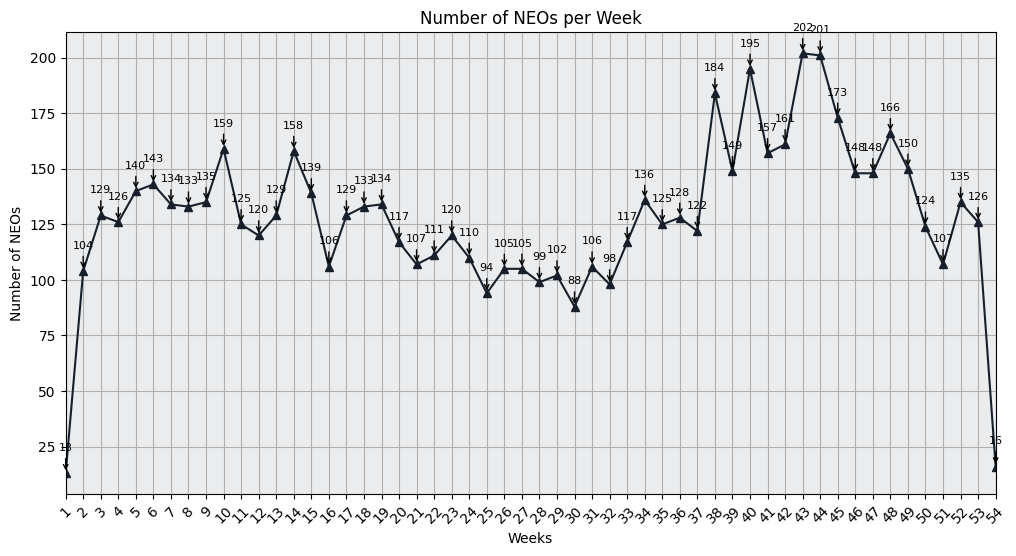

In [10]:





# Convert the 'close_approach_date' column to datetime type
full_relevant_approach_df['close_approach_date'] = pd.to_datetime(full_relevant_approach_df['close_approach_date'])

# Group the NEOs by week and count the number of NEOs per week
neos_per_week = full_relevant_approach_df.groupby(pd.Grouper(key='close_approach_date', freq='W')).size()

# Create a gradient color map for the line plot
color_map = mcolors.LinearSegmentedColormap.from_list('ColorMap', ['#17202A', '#E74C3C'])

# Create a list of markers for the line plot
markers = ['o', 's', '^', 'D', 'v', 'p']

# Create the line plot
plt.figure(figsize=(12, 6))
neos_per_week.plot(color=color_map(np.linspace(0, 1, len(neos_per_week))), marker=np.random.choice(markers))
plt.xlabel('Weeks')
plt.ylabel('Number of NEOs')
plt.title('Number of NEOs per Week')
plt.grid(True)

# Add a gradient background
ax = plt.gca()
ax.set_facecolor('#EAECEE')

# Annotate all data points
for index, value in neos_per_week.items():
    plt.annotate(value, xy=(index, value), xytext=(index, value + 10), ha='center', fontsize=8,
                 arrowprops=dict(arrowstyle='->', color='black'))

# Set the x-axis tick labels as week numbers
week_numbers = range(1, len(neos_per_week) + 1)
plt.xticks(neos_per_week.index, week_numbers, rotation=45)

plt.show()

# below plot is based on Mon-Sun, whereas the original data is Sun-Sun


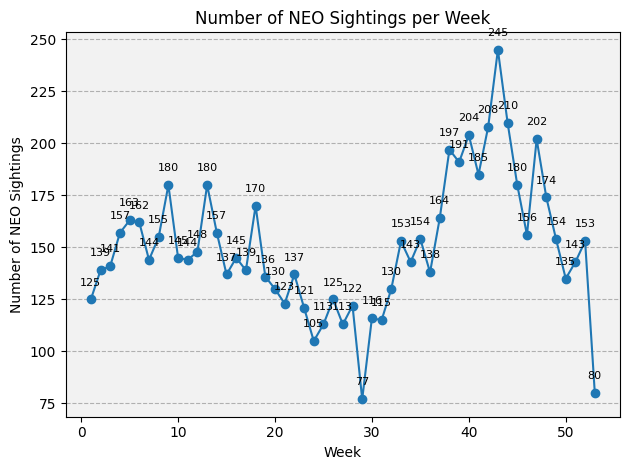

In [13]:
week_numbers = []
element_counts = []
counter = 1

# Iterating over each week's data
for week_data in data:
    element_count = week_data['element_count']
    week_date = list(week_data['near_earth_objects'].keys())[0]
    
    # Extracting the week number from the date
    week_number = pd.to_datetime(week_date).week
    
    week_numbers.append(counter)
    element_counts.append(element_count)
    
    #print(f"Week: {counter}, Number of NEO Sightings: {element_count}")
    
    counter += 1

# The line plot
plt.plot(week_numbers, element_counts, marker='o')
# a background color to the plot area
plt.gca().set_facecolor('#f2f2f2')
# gridlines for better readability
plt.grid(axis='y', linestyle='--')

# Annotate the curve
for i in range(len(week_numbers)):
    plt.annotate(
        element_counts[i],  # Text to display
        (week_numbers[i], element_counts[i]),  # Position of the point to annotate
        textcoords="offset points",  # Offset the text slightly
        xytext=(0, 10),  # Position the text above the point
        ha='center',  # Horizontal alignment
        fontsize=8  # Font size of the annotation
    )

plt.xlabel('Week')
plt.ylabel('Number of NEO Sightings')
plt.title('Number of NEO Sightings per Week')
plt.tight_layout()
plt.show()


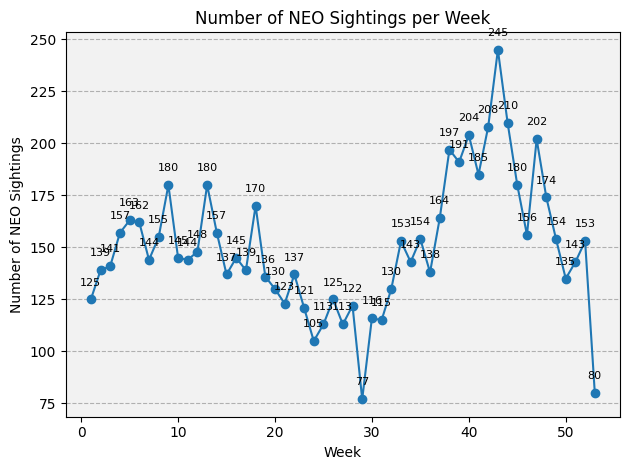

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

week_numbers = []
element_counts = []
counter = 1

# Iterating over each week's data
for week_data in data:
    element_count = week_data['element_count']
    week_date = list(week_data['near_earth_objects'].keys())[0]
    
    # Extracting the week number from the date
    week_number = pd.to_datetime(week_date).week
    
    week_numbers.append(counter)
    element_counts.append(element_count)
    
    counter += 1

# Create a DataFrame
df = pd.DataFrame({'Week': week_numbers, 'Number of NEO Sightings': element_counts})

# The line plot
plt.plot(df['Week'], df['Number of NEO Sightings'], marker='o')
# Add a background color to the plot area
plt.gca().set_facecolor('#f2f2f2')
# Add gridlines for better readability
plt.grid(axis='y', linestyle='--')

# Annotate the curve
for i in range(len(df)):
    plt.annotate(
        df['Number of NEO Sightings'][i],  # Text to display
        (df['Week'][i], df['Number of NEO Sightings'][i]),  # Position of the point to annotate
        textcoords="offset points",  # Offset the text slightly
        xytext=(0, 10),  # Position the text above the point
        ha='center',  # Horizontal alignment
        fontsize=8  # Font size of the annotation
    )

plt.xlabel('Week')
plt.ylabel('Number of NEO Sightings')
plt.title('Number of NEO Sightings per Week')
plt.tight_layout()
plt.show()

##### Task 3.2 (Create a histogram of the distribution of NEO sizes.)

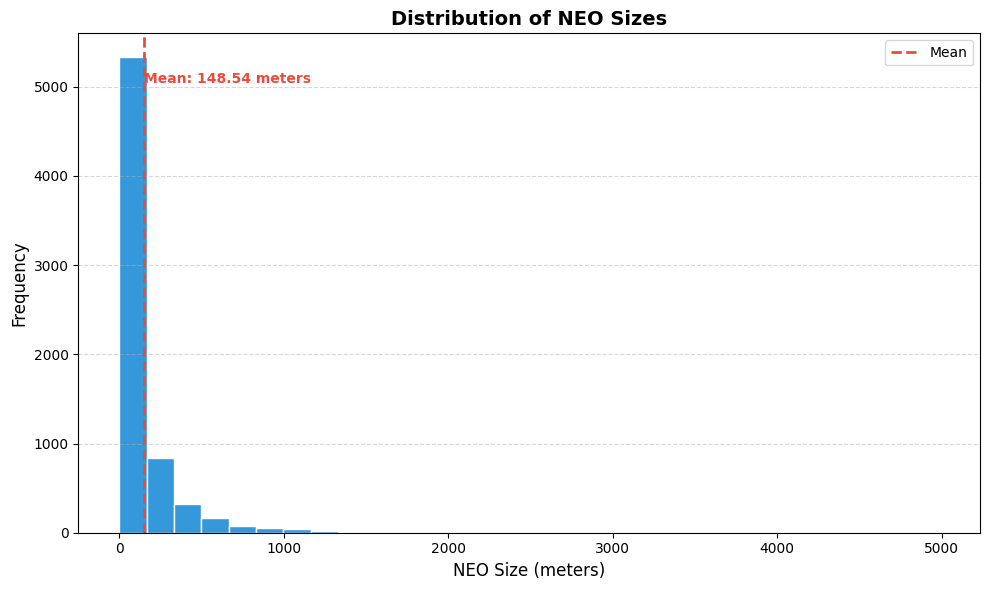

In [15]:
# Extract the NEO sizes
neo_sizes = full_relevant_approach_df['estimated_diameter.meters.estimated_diameter_avg']

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(neo_sizes, bins=30, color='#3498DB', edgecolor='white')

# Set the labels and title
plt.xlabel('NEO Size (meters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of NEO Sizes', fontsize=14, fontweight='bold')

# Add gridlines
plt.grid(True, axis='y', linestyle='dashed', alpha=0.5)

# Add a vertical line for the mean
mean_size = neo_sizes.mean()
plt.axvline(mean_size, color='#E74C3C', linestyle='dashed', linewidth=2, label='Mean')

# Add legend
plt.legend()

# Add text annotation for the mean
plt.text(mean_size + 5, plt.ylim()[1] * 0.9, f'Mean: {mean_size:.2f} meters',
         color='#E74C3C', fontsize=10, fontweight='bold')

# Customize tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


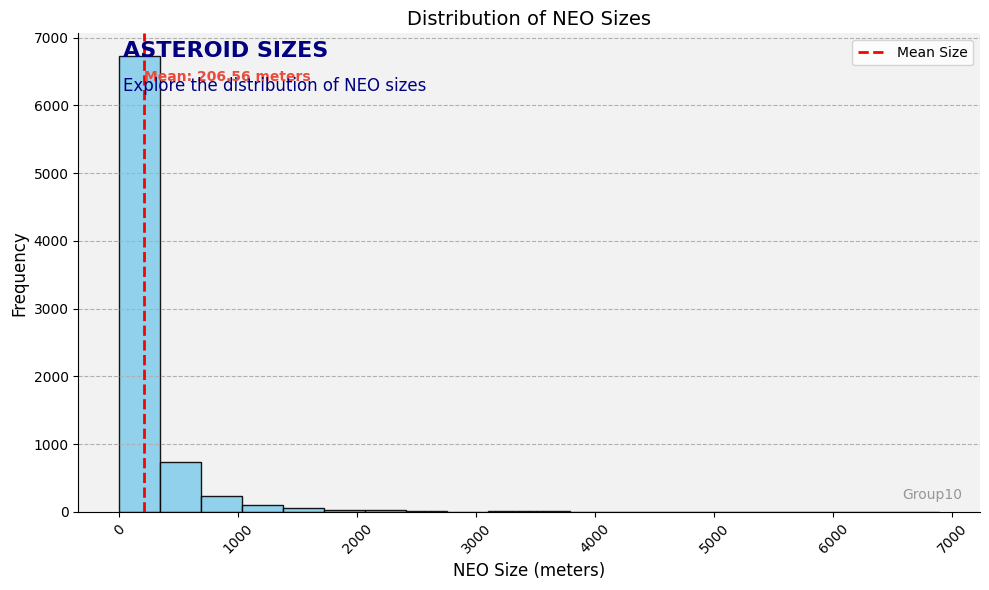

In [96]:
neo_sizes = []
for item in data:
    for date, neos in item['near_earth_objects'].items():
        for neo in neos:
            size = neo['estimated_diameter']['meters']['estimated_diameter_max']
            neo_sizes.append(float(size))

# the histogram
plt.figure(figsize=(10, 6))
plt.hist(neo_sizes, bins=20, edgecolor='black', color='skyblue', alpha=0.9)  # Adjust the number of bins as needed

#  a vertical line for the mean size
mean_size = np.mean(neo_sizes)
plt.axvline(mean_size, color='red', linestyle='--', linewidth=2, label='Mean Size')

#  text annotation for the mean size
#plt.text(mean_size, plt.ylim()[1]*0.9, f'Mean Size: {mean_size:.2f} meters', color='red',
         #ha='center', va='top', fontweight='bold')

# Customizing the plot
plt.xlabel('NEO Size (meters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of NEO Sizes', fontsize=14)
plt.legend()

#  gridlines for better readability
plt.grid(axis='y', linestyle='--')

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45)

# a background color to the plot area
plt.gca().set_facecolor('#f2f2f2')

# Add text annotation for the mean
plt.text(mean_size + 5, plt.ylim()[1] * 0.9, f'Mean: {mean_size:.2f} meters',
         color='#E74C3C', fontsize=10, fontweight='bold')
# some decorative elements
plt.text(0.05, 0.95, 'ASTEROID SIZES', transform=plt.gca().transAxes,
         fontsize=16, fontweight='bold', color='navy')
plt.text(0.05, 0.88, 'Explore the distribution of NEO sizes', transform=plt.gca().transAxes,
         fontsize=12, color='navy')

# a watermark
plt.text(0.98, 0.02, 'Group10', transform=plt.gca().transAxes,
         fontsize=10, color='gray', ha='right', va='bottom', alpha=0.8)

# Removing top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Task 3.3 (Create a bar plot of the average NEO size per week.)

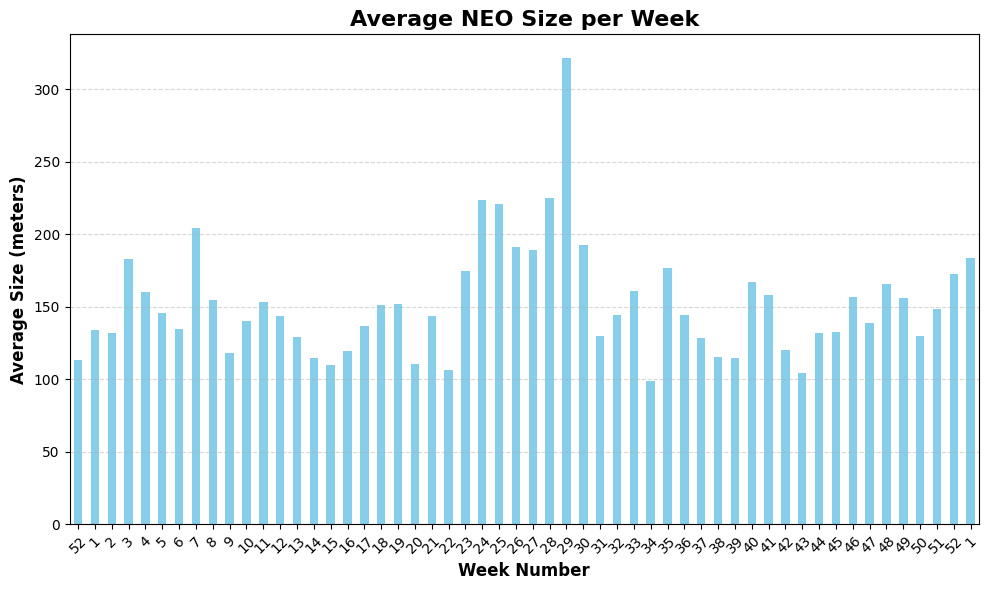

In [97]:
# Convert the 'close_approach_date' column to datetime type
full_relevant_approach_df['close_approach_date'] = pd.to_datetime(full_relevant_approach_df['close_approach_date'])

# Group the NEOs by week and calculate the average size
avg_size_per_week = full_relevant_approach_df.groupby(pd.Grouper(key='close_approach_date', freq='W'))['estimated_diameter.meters.estimated_diameter_avg'].mean()

# Create the bar plot
plt.figure(figsize=(10, 6))
avg_size_per_week.plot(kind='bar', color='skyblue')

# Set the plot title and axis labels
plt.title('Average NEO Size per Week', fontsize=16, fontweight='bold')
plt.xlabel('Week Number', fontsize=12, fontweight='bold')
plt.ylabel('Average Size (meters)', fontsize=12, fontweight='bold')

# Set x-axis tick labels as week numbers
week_numbers = avg_size_per_week.index.isocalendar().week
plt.xticks(range(len(week_numbers)), week_numbers, rotation=45)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add a background color for the annotations
bbox_props = dict(boxstyle='round,pad=0.3', fc='white', ec='gray', lw=0.5)

# Increase the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()




In [98]:
week_numbers = []
average_sizes = []

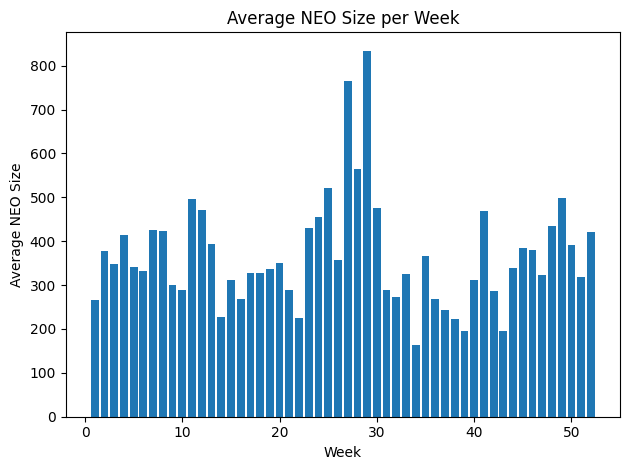

In [100]:

# Calculate the average NEO size per week
for week_data in data:
    neos = week_data['near_earth_objects']
    for date, neo_list in neos.items():
        average_size = sum(neo['estimated_diameter']['meters']['estimated_diameter_max'] for neo in neo_list) / len(neo_list)
        week_number = pd.to_datetime(date).week

        week_numbers.append(week_number)
        average_sizes.append(average_size)

        #print(f"Week: {week_number}, Average NEO Size: {average_size}")

# Create the bar plot
plt.bar(week_numbers, average_sizes)
plt.xlabel('Week')
plt.ylabel('Average NEO Size')
plt.title('Average NEO Size per Week')
plt.tight_layout()
plt.show()

##### Task 3.4 (Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. Be creative!)

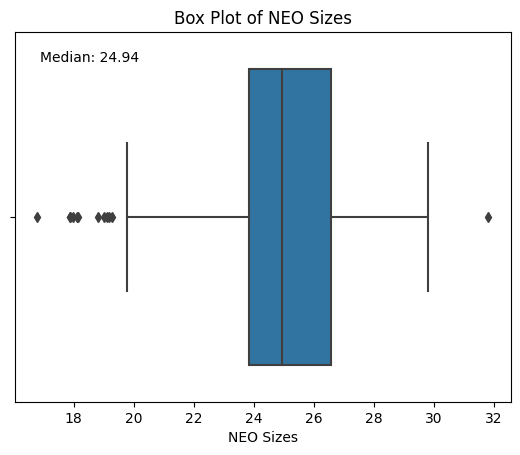

In [102]:

# Box plot of NEO sizes
ax = sns.boxplot(x=neo_df['abs magnitude'])
ax.set(xlabel='NEO Sizes', title='Box Plot of NEO Sizes')

# Annotate the median value
median_value = neo_df['abs magnitude'].median()
ax.text(0.05, 0.95, f'Median: {median_value:.2f}', transform=ax.transAxes, va='top')

plt.show()

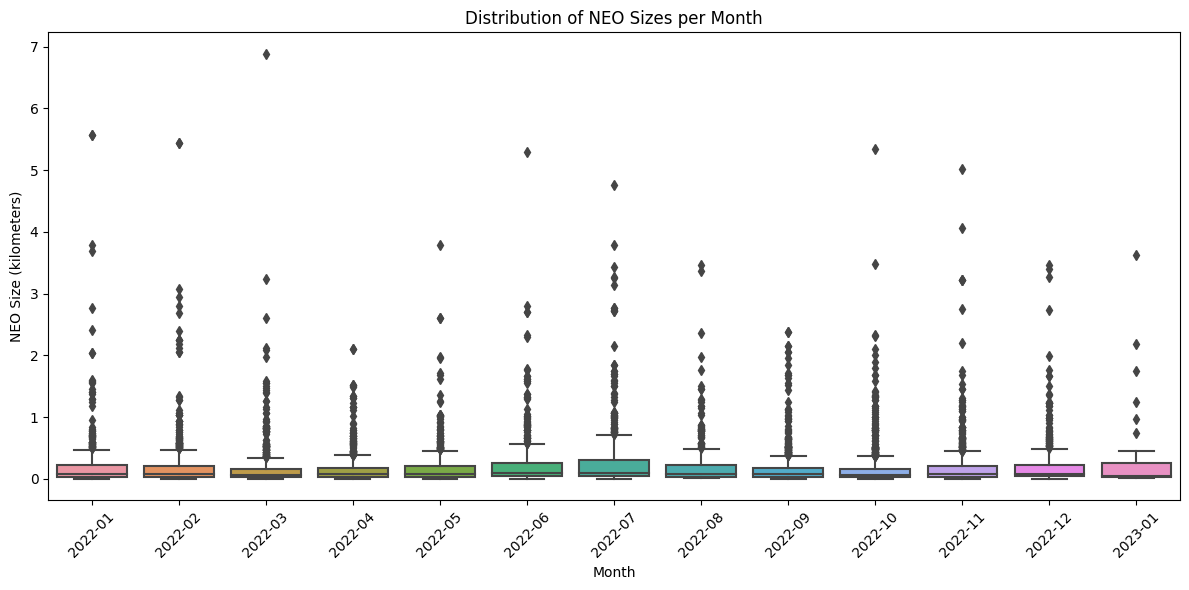

In [106]:


# Prepare the data for the box plot
neo_sizes = []
dates = []

for week_data in data:
    neos = week_data['near_earth_objects']
    for date, neo_list in neos.items():
        sizes = [neo['estimated_diameter']['meters']['estimated_diameter_max'] / 1000 for neo in neo_list]  # Convert meters to kilometers
        neo_sizes.extend(sizes)
        dates.extend([pd.to_datetime(date)] * len(sizes))

# Create a DataFrame for the box plot
df_boxplot = pd.DataFrame({'Date': dates, 'NEO Size (kilometers)': neo_sizes})

# Aggregate the NEO sizes on a monthly basis
df_boxplot['Month'] = df_boxplot['Date'].dt.to_period('M')

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='NEO Size (kilometers)', data=df_boxplot)
plt.xlabel('Month')
plt.ylabel('NEO Size (kilometers)')
plt.title('Distribution of NEO Sizes per Month')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


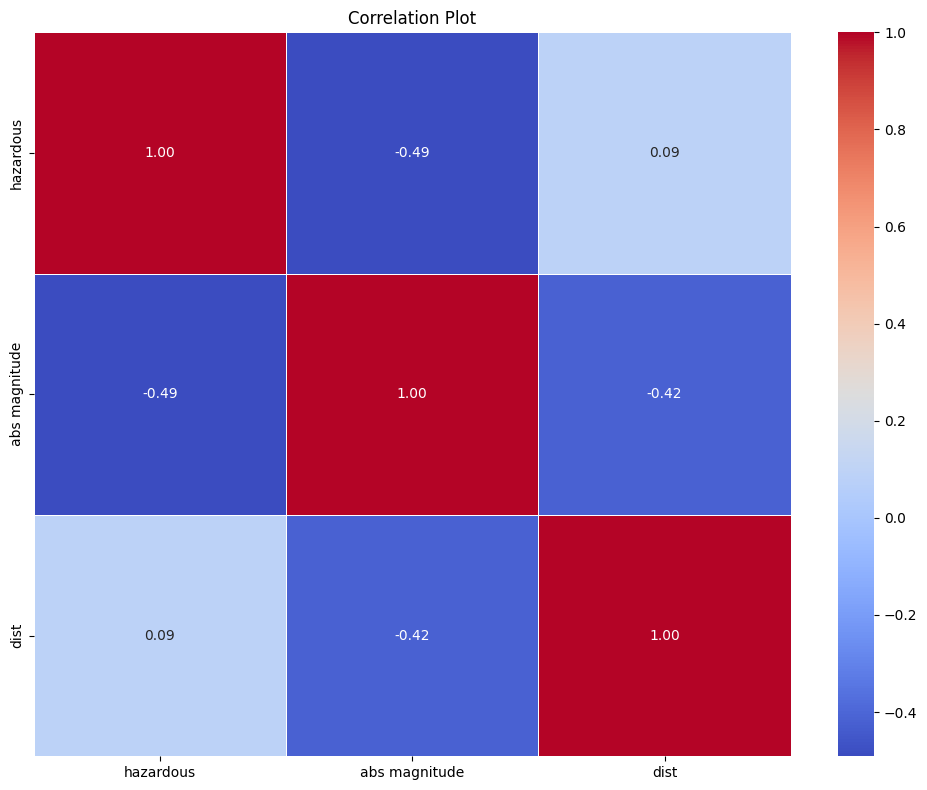

In [109]:


# Select the columns for correlation analysis
columns_for_correlation = [
    'relative_velocity.kilometers_per_second',
    'miss_distance.kilometers',
    'estimated_diameter.meters.estimated_diameter_min',
    'estimated_diameter.meters.estimated_diameter_max',
    'estimated_diameter.meters.estimated_diameter_avg'
]

# Subset the dataframe with the selected columns
#subset_df = full_relevant_approach_df[columns_for_correlation]

# Compute the correlation matrix
correlation_matrix = neo_df.corr(numeric_only=True)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Create the correlation plot using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

# Set the title
ax.set_title('Correlation Plot')

# Display the plot
plt.tight_layout()
plt.show()

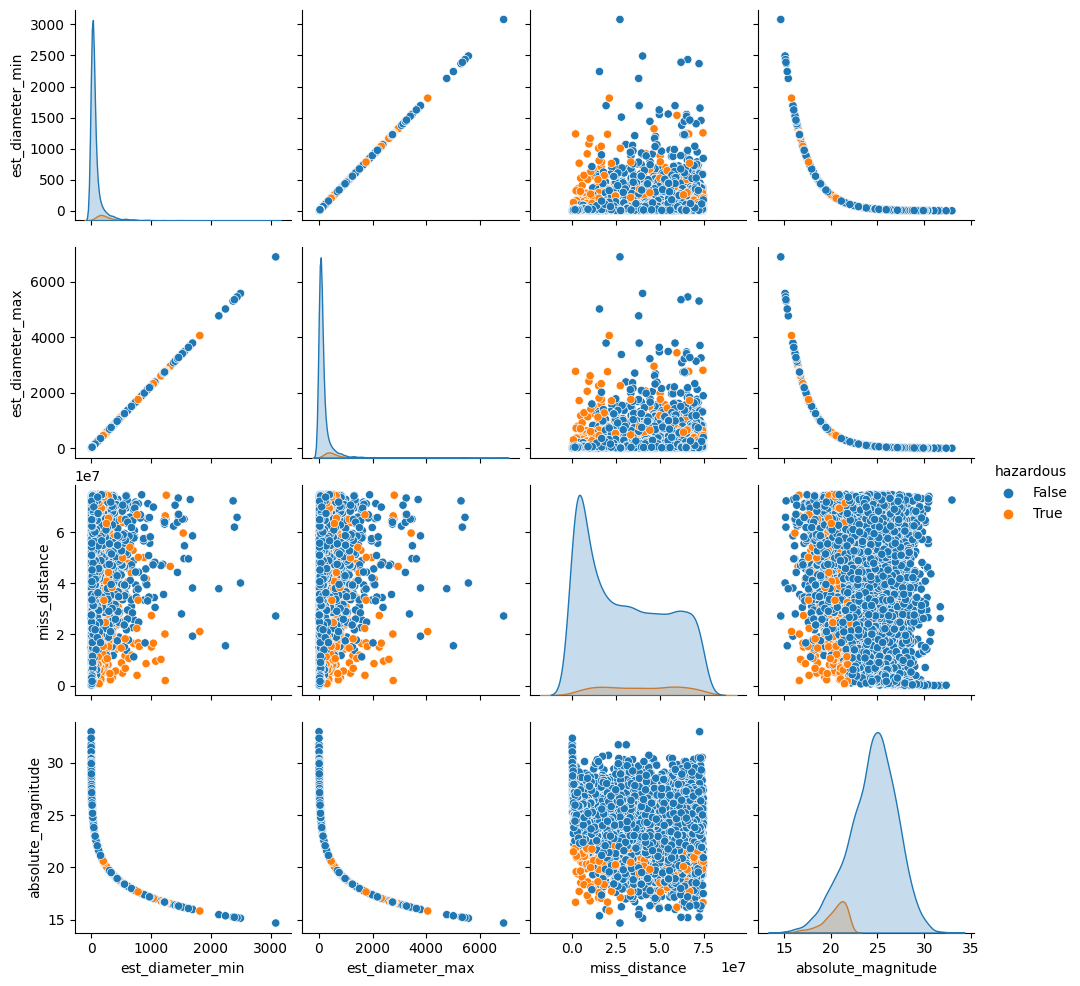

In [110]:


# Select the relevant columns from your dataset
selected_data = full_relevant_approach_df[['estimated_diameter.meters.estimated_diameter_min',
                           'estimated_diameter.meters.estimated_diameter_max',
                           'relative_velocity.kilometers_per_second',
                           'miss_distance.kilometers',
                           'absolute_magnitude_h',
                           'is_potentially_hazardous_asteroid']]

# Rename the columns if needed
selected_data = selected_data.rename(columns={'estimated_diameter.meters.estimated_diameter_min': 'est_diameter_min',
                                              'estimated_diameter.meters.estimated_diameter_max': 'est_diameter_max',
                                              'relative_velocity.kilometers_per_second': 'relative_velocity',
                                              'miss_distance.kilometers': 'miss_distance',
                                              'absolute_magnitude_h': 'absolute_magnitude',
                                              'is_potentially_hazardous_asteroid': 'hazardous'})

# Create the pair plot
sns.pairplot(data=selected_data, hue='hazardous')

# Show the plot
plt.show()


In [111]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6921 entries, 0 to 15
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   est_diameter_min    6921 non-null   float64
 1   est_diameter_max    6921 non-null   float64
 2   relative_velocity   6921 non-null   object 
 3   miss_distance       6921 non-null   float64
 4   absolute_magnitude  6921 non-null   object 
 5   hazardous           6921 non-null   object 
dtypes: float64(3), object(3)
memory usage: 378.5+ KB


In [112]:
selected_data.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,40.230458,89.958039,10.1548261794,2.118674e+07,24.1,False
1,48.367649,108.153351,13.5100245697,2.582431e+07,23.7,False
2,66.765941,149.293183,20.4077209528,7.408668e+07,23.0,False
3,22.108281,49.435619,8.4332699552,7.229155e+07,25.4,False
4,10.105434,22.596438,14.9839822861,5.897189e+07,27.1,False


### Task 4: Data Visualization Part B

- Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.
- Create a scatter plot of the correlation between NEO size and close approach distance.
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

#### Taks 4.1 (Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.)

total_hazardous_count 456
total_non_hazardous_count 6465


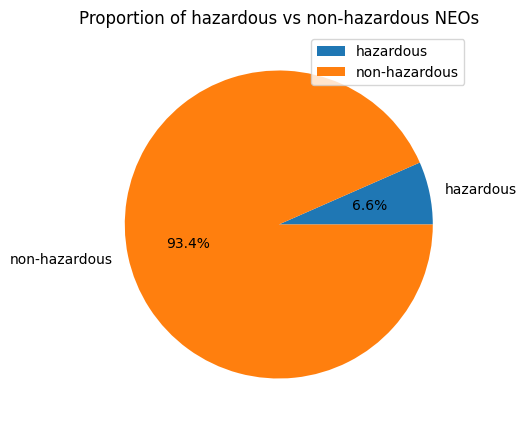

In [113]:
print("total_hazardous_count", total_hazardous_count)
print("total_non_hazardous_count", total_non_hazardous_count)
hazardous_df = pd.DataFrame({'count': [total_hazardous_count, total_non_hazardous_count]}, index=['hazardous', 'non-hazardous'])
hazardous_plot = hazardous_df.plot.pie(y='count', ylabel='', figsize=(5,5), autopct='%1.1f%%', title="Proportion of hazardous vs non-hazardous NEOs")

#### Task 4.2, 4.3 & 4,4:
- (Create a scatter plot of the correlation between NEO size and close approach distance.)
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

In [27]:
# use plotly express for interactive scatterplot
fig = px.scatter(full_relevant_approach_df, x='estimated_diameter.meters.estimated_diameter_avg', y='miss_distance.kilometers', color='is_potentially_hazardous_asteroid', 
                 color_discrete_sequence=["green", "red"],
                 hover_data=['close_approach_date', 'orbiting_body', 'relative_velocity.kilometers_per_second', 'name', 'absolute_magnitude_h', 'estimated_diameter.meters.estimated_diameter_min', 'estimated_diameter.meters.estimated_diameter_max'], 
                 labels={
                     "estimated_diameter.meters.estimated_diameter_avg": "NEO size - average diameter (m)",
                     "miss_distance.kilometers": "Close approach distance (km)",
                 },
                 title="NEO size vs close approach distance")
fig.update_layout(legend_title="Hazardous asteroid")
fig.show()
# export for viewing in html
fig.write_html("neo_size_vs_close_approach_distance.html")

### Task 5: Interpretation of Results

<!-- There is no correlation between average NEO size and its close approach distance.  -->
There are no hazardous asteroids with a NEO size less than 150m in average diameter. 

### Task 6: Presentation and Documentation

- Make this project as part of your presentation, **using beamer in LaTeX**. 
- This should include an overview of your work, the results of your data analysis, and the insights you gained from your results.